In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from itertools import product
# time series tools
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing

## 1. Prepare data
### 1.1 Read data

In [2]:
df = pd.read_csv('../data/MPS_actions/use_force/UF_aggregated_22_23.csv', index_col=0)
df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12149 entries, 0 to 12148
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IncidentDate  12149 non-null  object
 1   Borough       12149 non-null  object
 2   counts        12149 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 379.7+ KB


### 1.2 Detect missing borough 

In [4]:
unique_dates = df['IncidentDate'].unique()
unique_boroughs = df['Borough'].unique()

In [5]:
print(unique_dates.shape, unique_boroughs.shape)

(365,) (34,)


In [6]:
# Всего должно быть строк в матрице
365*34

12410

In [7]:
# Пропущено столько строк
12410 - 12149

261

In [8]:
# не эффективная процедура, лучше проходить по самим строкам в pandas
missed_data = []
for d,b in product(unique_dates,unique_boroughs):
    if df[(df['IncidentDate'] == d)&(df['Borough'] == b)].empty:
        missed_data.append({
            'IncidentDate' :d,
            'Borough':b,
            'counts':0            
        })
        # print(d,b)

In [9]:
len(missed_data)

261

### 1.3 Add missing values

In [10]:
df_missed_data = pd.DataFrame(missed_data)
df_missed_data.head()

,IncidentDate,Borough,counts
0,2022-04-01,Kingston upon Thames,0
1,2022-04-01,Heathrow,0
2,2022-04-02,Heathrow,0
3,2022-04-06,Kensington and Chelsea,0
4,2022-04-08,Richmond upon Thames,0


In [11]:
full_df = pd.concat([df, df_missed_data], ignore_index=True )

In [12]:
full_df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


In [13]:
full_df.tail()

,IncidentDate,Borough,counts
12405,2023-03-26,Out of force,0
12406,2023-03-26,Richmond upon Thames,0
12407,2023-03-26,Heathrow,0
12408,2023-03-27,Out of force,0
12409,2023-03-27,Heathrow,0


In [14]:
full_df.sort_values(by=['IncidentDate','Borough'],inplace=True,ignore_index=True)

In [15]:
full_df.head()

,IncidentDate,Borough,counts
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


In [16]:
full_df.tail()

,IncidentDate,Borough,counts
12405,2023-03-31,Southwark,19
12406,2023-03-31,Sutton,2
12407,2023-03-31,Tower Hamlets,11
12408,2023-03-31,Waltham Forest,4
12409,2023-03-31,Wandsworth,3


change name to Prophet standard

In [17]:
full_df = full_df.rename(columns={'IncidentDate': 'ds', 'counts':'y'})
full_df.head()

,ds,Borough,y
0,2022-04-01,Barking and Dagenham,9
1,2022-04-01,Barnet,7
2,2022-04-01,Bexley,5
3,2022-04-01,Brent,12
4,2022-04-01,Bromley,19


### 1.4 Split data

In [18]:
train = full_df.loc[full_df['ds'] < '2023-02-15']
valid = full_df.loc[(full_df['ds'] >= '2023-02-15')]  

In [19]:
train.tail()

,ds,Borough,y
10875,2023-02-14,Southwark,14
10876,2023-02-14,Sutton,6
10877,2023-02-14,Tower Hamlets,17
10878,2023-02-14,Waltham Forest,8
10879,2023-02-14,Wandsworth,13


# 2 Make predictions for each borough

# 2.1 Metrics

In [20]:
def wmape(y_true, y_pred):
    return 100*np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [35]:
def smape(y_true, y_pred):
    eps = np.ones_like(y_true)*0.1
    return (np.abs(y_true - y_pred) / np.max([y_true,y_pred,eps],axis=0)).sum()*(100/np.max(y_true.shape))

In [36]:
# print('np.max: ', np.max(np.array([np.array([3,4,8]),np.array([1,5,7])]),axis=0))
# v1 = np.array([0,4,8])
# v2 = np.array([3,5,7])

# print('wmape: ',wmape(v1,v2))
# print('smape: ',smape(v1,v2))

# df1 = pd.DataFrame({'a': ['foo', 'bar'], 'b': [1, 2]})
# df2 = pd.DataFrame({'a': ['foo', 'baz'], 'c': [3, 4]})
# print('np.max: ', np.max([df1['b'], df2['c']],axis=0))

# 2.2 Forecasting 

In [37]:
# параметры для экспоненциального сглаживания 
season_type = 'additive'
seas_period_ = 7

p = list()
metrics = list()
for borough in unique_boroughs:
    # if borough=='Brent':
    #     break
    print(f'Borough: {borough}')
    # выделяем данные только одного района
    train_ = train.loc[train['Borough'] == borough]
    valid_ = valid.loc[valid['Borough'] == borough]
    horizon_ = valid_.shape[0]
    # Строим модель Prophet с годовой и недельной сезонностью
    myw = Prophet(seasonality_mode='additive', yearly_seasonality=True, 
                weekly_seasonality=True, daily_seasonality=False)    
    myw.fit(train_)
    # Если include_history=True, то получим значения модели для всего
    # набора данных (надо для сравнения моделей и картинок)
    future_myw = myw.make_future_dataframe(periods=valid_.shape[0], include_history=False)
    forecast_myw = myw.predict(future_myw)
    
    forecast_myw.rename(columns={'yhat': 'prophet_yw'}, inplace=True)
    
    # Строим модель Prophet только с недельной сезонностью
    mw = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=False)    
    mw.fit(train_)
    # Если include_history=True, то получим значения модели для всего
    # набора данных (надо для сравнения моделей и картинок)
    future_mw = mw.make_future_dataframe(periods=valid_.shape[0], include_history=False)
    forecast_mw = mw.predict(future_mw)
    forecast_mw.rename(columns={'yhat': 'prophet_w'}, inplace=True)
    
    
    # Строим модель Экспоненциального сглаживания
    m_exp_sm = ExponentialSmoothing(train_[['y']].values,
                            seasonal_periods=seas_period_,
                            trend='additive',
                            seasonal=season_type,
                            damped_trend=True).fit()
    
    # Прогноз модели для всего набора данных (надо для сравнения моделей и картинок)
    # forecast_exp_sm = m_exp_sm.predict(0, train_.shape[0] + horizon_ - 1)
    
    # Прогноз модели только для значений valid_
    forecast_exp_sm = m_exp_sm.predict(train_.shape[0], train_.shape[0] + horizon_ - 1)
       
    # Объединяем прогнозы разных моделей
    output = valid_[['ds','y']].reset_index(drop=True).copy()
    output['Borough'] = borough
    output['exp_sm'] = forecast_exp_sm
    output['prophet_yw'] = forecast_myw['prophet_yw']
    output['prophet_w'] = forecast_mw['prophet_w']
    
    # print(output)
    p.append(output)
    borough_metrics = {'Borough':borough}
    borough_metrics.update({
        col + '_' + func.__name__ : np.round(func(output['y'], output[col]),3) for col in ['exp_sm','prophet_yw','prophet_w'] for func in [wmape, smape]
        })
    metrics.append(borough_metrics)
    
    # print(metrics)
    # break 
london_forecast = pd.concat(p, ignore_index=True)
df_metrics = pd.DataFrame(metrics)


18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing


Borough: Barking and Dagenham


18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing


Borough: Barnet


18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing


Borough: Bexley


18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing


Borough: Brent


18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing


Borough: Bromley


18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing


Borough: Camden


18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing


Borough: City of Westminster


18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing


Borough: Croydon


18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing


Borough: Ealing


18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing


Borough: Enfield


18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing


Borough: Greenwich


18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing


Borough: Hackney


18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing


Borough: Hammersmith and Fulham


18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing


Borough: Haringey


18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing


Borough: Harrow


18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing


Borough: Havering


18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing


Borough: Hillingdon


18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing


Borough: Hounslow


18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing


Borough: Islington


18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing


Borough: Kensington and Chelsea


18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing


Borough: Lambeth


18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing


Borough: Lewisham


18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing


Borough: Merton


18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing


Borough: Newham


18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing


Borough: Out of force


18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing


Borough: Redbridge


18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing


Borough: Richmond upon Thames


18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing


Borough: Southwark


18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing


Borough: Sutton


18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing


Borough: Tower Hamlets


18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing


Borough: Waltham Forest


18:11:19 - cmdstanpy - INFO - Chain [1] start processing
18:11:19 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing


Borough: Wandsworth


18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing


Borough: Kingston upon Thames


18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing


Borough: Heathrow


18:11:23 - cmdstanpy - INFO - Chain [1] start processing
18:11:23 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
london_forecast

,ds,y,Borough,exp_sm,prophet_yw,prophet_w
0,2023-02-15,2,Barking and Dagenham,9.390935,9.663560,9.738688
1,2023-02-16,13,Barking and Dagenham,8.919031,9.011173,9.249965
2,2023-02-17,22,Barking and Dagenham,8.746705,8.708043,9.105844
3,2023-02-18,9,Barking and Dagenham,9.034515,8.841800,9.388430
4,2023-02-19,6,Barking and Dagenham,7.124071,6.797243,7.475955
...,...,...,...,...,...,...
1525,2023-03-27,0,Heathrow,2.360903,2.846978,2.199692
1526,2023-03-28,1,Heathrow,2.814812,3.363684,2.668749
1527,2023-03-29,1,Heathrow,1.986325,2.544402,1.819505
1528,2023-03-30,1,Heathrow,2.384613,2.984907,2.228839


In [39]:
df_metrics

,Borough,exp_sm_wmape,exp_sm_smape,prophet_yw_wmape,prophet_yw_smape,prophet_w_wmape,prophet_w_smape
0,Barking and Dagenham,41.265,32.547,45.802,34.397,41.508,32.660
1,Barnet,37.579,31.349,39.122,31.466,37.997,32.155
2,Bexley,35.219,29.260,38.658,31.355,35.039,29.237
3,Brent,40.445,30.691,46.937,35.871,39.630,30.393
4,Bromley,38.793,31.295,50.527,43.512,43.254,35.780
5,Camden,38.152,30.300,38.963,30.611,36.990,29.514
6,City of Westminster,35.982,29.578,58.771,52.325,36.723,30.622
7,Croydon,29.401,25.689,60.112,57.206,34.868,30.895
8,Ealing,29.270,24.817,29.411,25.028,31.229,27.010
9,Enfield,38.684,32.200,41.591,33.653,40.683,34.235


# Conclusions 

In [40]:
def analyse_borough(borough, df_forecast, df_metrics):
    data = df_forecast.loc[df_forecast['Borough'] == borough]        
    fig, ax = plt.subplots()

    models = ['exp_sm', 'prophet_yw', 'prophet_w']
    for model in models:
        ax.plot(data['ds'], data[model], label=str(model))    
    ax.plot(data['ds'], data['y'], label= 'y_true')    
    ax.set_xlabel('Days')
    ax.set_ylabel('Events')
    ax.set_title(f'Forcast for {borough}')
    ax.legend(loc='best')
    x_index = np.arange(0,data.shape[0],10)
    plt.xticks(x_index, data['ds'].iloc[x_index]);    
    plt.tight_layout()
    
    print(df_metrics.loc[df_metrics['Borough'] == borough])
    

  Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  prophet_yw_smape  \
1  Barnet        37.579        31.349            39.122            31.466   

   prophet_w_wmape  prophet_w_smape  
1           37.997           32.155  


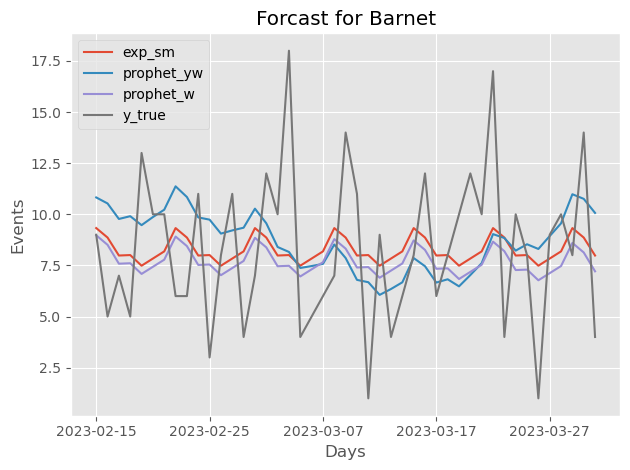

In [41]:
analyse_borough('Barnet',london_forecast,df_metrics)

  Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  prophet_yw_smape  \
1  Barnet        37.579        31.349            39.122            31.466   

   prophet_w_wmape  prophet_w_smape  
1           37.997           32.155  


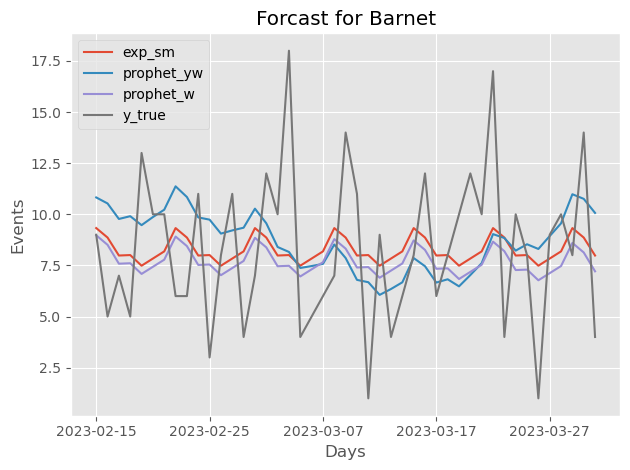

In [42]:
analyse_borough('Barnet',london_forecast,df_metrics)

     Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  prophet_yw_smape  \
33  Heathrow        82.099        54.319           101.247             91.95   

    prophet_w_wmape  prophet_w_smape  
33           80.005           54.708  


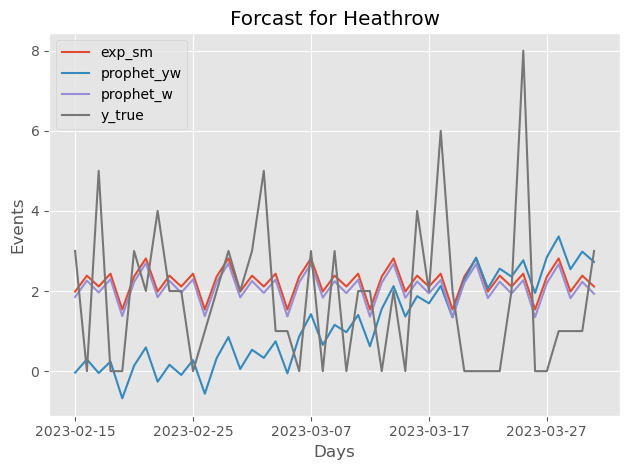

In [43]:
analyse_borough('Heathrow',london_forecast,df_metrics)

                 Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  \
32  Kingston upon Thames        47.987        37.721            50.557   

    prophet_yw_smape  prophet_w_wmape  prophet_w_smape  
32            40.668           48.374             38.3  


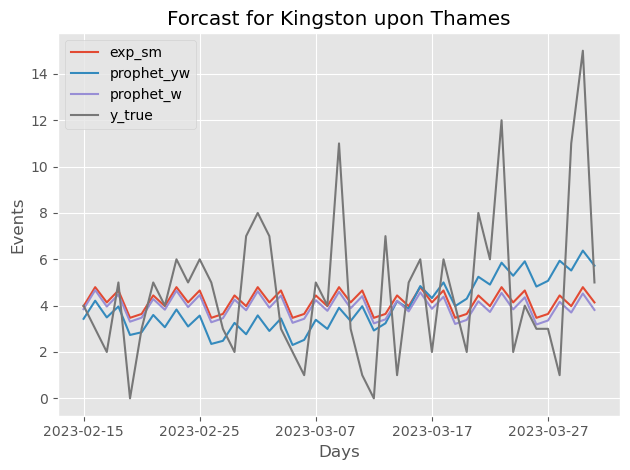

In [44]:
analyse_borough('Kingston upon Thames',london_forecast,df_metrics)

                 Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  \
26  Richmond upon Thames        59.992        46.669            73.625   

    prophet_yw_smape  prophet_w_wmape  prophet_w_smape  
26             63.61           61.339           48.925  


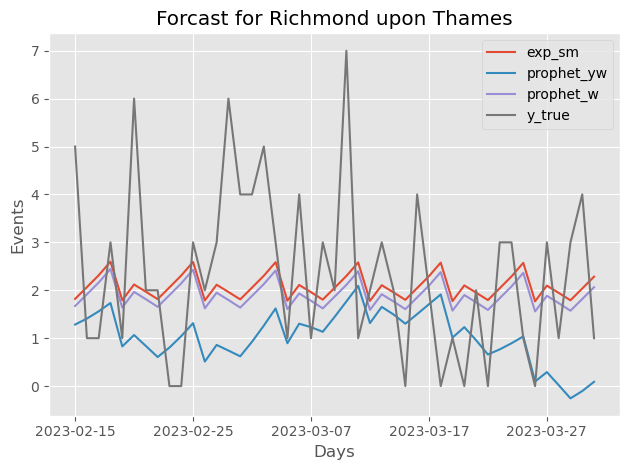

In [45]:
analyse_borough('Richmond upon Thames',london_forecast,df_metrics)

                   Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  \
19  Kensington and Chelsea        63.129        45.827            62.391   

    prophet_yw_smape  prophet_w_wmape  prophet_w_smape  
19            47.779           64.495           49.622  


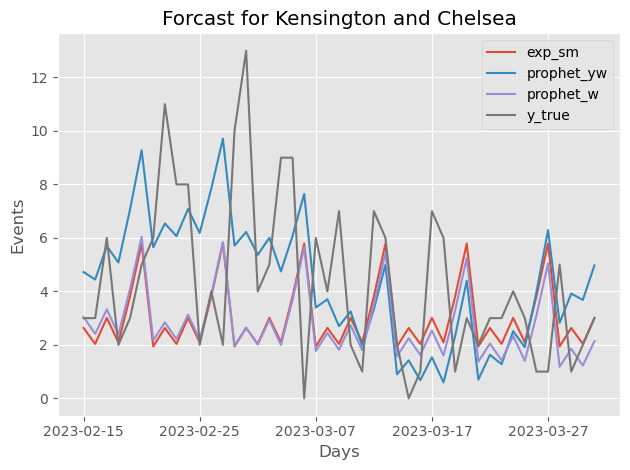

In [46]:
analyse_borough('Kensington and Chelsea',london_forecast,df_metrics)

         Borough  exp_sm_wmape  exp_sm_smape  prophet_yw_wmape  \
24  Out of force        71.152        51.683            98.723   

    prophet_yw_smape  prophet_w_wmape  prophet_w_smape  
24            55.824           68.981           51.643  


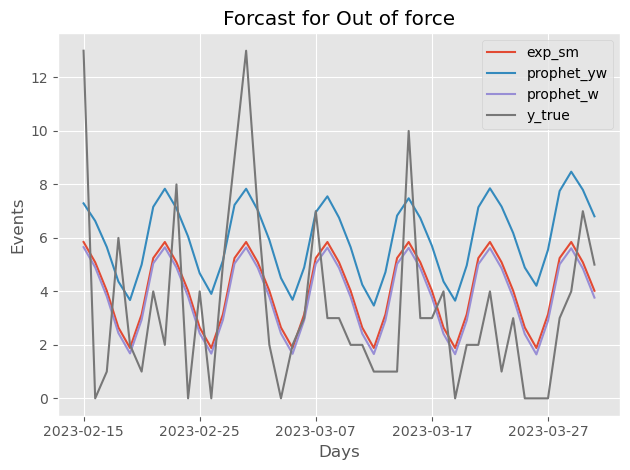

In [47]:
analyse_borough('Out of force',london_forecast,df_metrics)

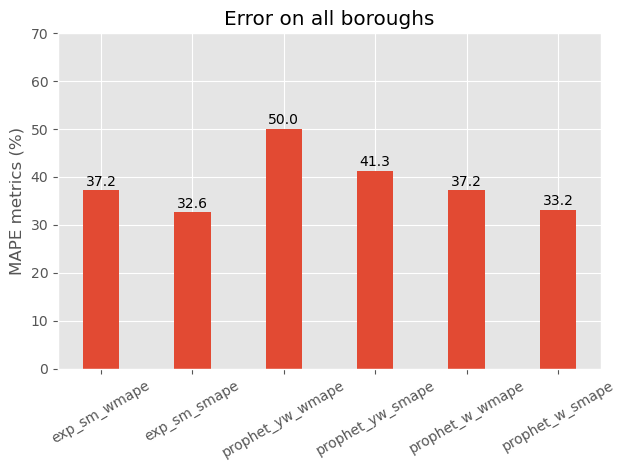

In [48]:
# вывести разные значения ошибок моделей для всех районов

fig, ax = plt.subplots()
result = {
    col + '_' + func.__name__ : np.round(func(london_forecast['y'], london_forecast[col]),1) for col in ['exp_sm','prophet_yw','prophet_w'] for func in [wmape, smape] 
}

ax.bar(result.keys(), result.values(), width=0.4)
plt.xticks(rotation=30)
ax.set_title('Error on all boroughs')
ax.set_xlabel('')
ax.set_ylabel('MAPE metrics (%)')
ax.set_ylim(0, 70)

for index, value in enumerate(result.values()):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')
    
plt.tight_layout()

При сравнении построении простых моделей, мы получаем, что экспоненциальное сглаживание и модель prophet без годовой сезонности показали себя лучше, чем модель prophet с годовой сезонностью.

Возможно для улучшения моделей следует:
- в модель prophet добавить праздники,
- обогатить данные дополнительными данными о районах или важных событиях города.